In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Data Read & Feature Engineering

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

train_df = pd.read_csv('train.csv')
submit_df = pd.read_csv('sample_submission.csv')
med_df = pd.read_csv('med.csv')

med_df["Yıl"] = pd.to_datetime(med_df["Tarih"]).dt.year
med_df["Ay"] = pd.to_datetime(med_df["Tarih"]).dt.month
med_df["Gün"] = pd.to_datetime(med_df["Tarih"]).dt.day

train_df["Yıl"] = pd.to_datetime(train_df["Tarih"]).dt.year
train_df["Ay"] = pd.to_datetime(train_df["Tarih"]).dt.month
train_df["Gün"] = pd.to_datetime(train_df["Tarih"]).dt.day
train_df["Saat"] = pd.to_datetime(train_df["Tarih"]).dt.hour

submit_df["Yıl"] = pd.to_datetime(submit_df["Tarih"]).dt.year
submit_df["Ay"] = pd.to_datetime(submit_df["Tarih"]).dt.month
submit_df["Gün"] = pd.to_datetime(submit_df["Tarih"]).dt.day
submit_df["Saat"] = pd.to_datetime(submit_df["Tarih"]).dt.hour
submit_df["Kesintili Günler"]=0

train_df = train_df.drop("Tarih", axis=1)
submit_df = submit_df.drop("Tarih", axis=1)
med_df = med_df.drop("Tarih", axis=1)

med_df[['Yıl', 'Ay', 'Gün']] = med_df[['Yıl', 'Ay', 'Gün']].astype(int)
train_df['Kesintili Günler'] = train_df.apply(lambda row: int((row[['Yıl', 'Ay', 'Gün']] == med_df[['Yıl', 'Ay', 'Gün']]).all(axis=1).any()), axis=1)

In [ ]:
# from feat_engs import create_datetimes, create_businessDay_cumulativeholidays ,create_electricOutage_timeofDay , create_holiday_weekend , create_hourly_sin_cos , create_outage_rolling_percentages , create_seasons

# all_data = [train_df , submit_df , med_df]

# for df in all_data :
#     create_datetimes(df)
#     create_holiday_weekend(df)
#     create_businessDay_cumulativeholidays(df)
#     create_electricOutage_timeofDay(df , med_df)
#     create_hourly_sin_cos(df)
#     create_outage_rolling_percentages(df)
#     create_seasons(df)
#     df.set_index('Tarih' , inplace=True)
#     df.drop('date' , axis = 1 ,inplace=True)

In [9]:
calendar = pd.read_csv('Turkish_calendar.csv',sep=(";"))
new_df = calendar.iloc[853:2557].copy()
new_df.loc[:, "Ay"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.month
new_df.loc[:, "Yıl"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.year
new_df = new_df.drop(["SEASON_SK", "SPECIAL_DAY_SK", "SPECIAL_DAY_SK2"], axis=1)

In [11]:
new_df["WEEKEND_FLAG"] =new_df["WEEKEND_FLAG"].replace(["N"],0)
new_df["WEEKEND_FLAG"] =new_df["WEEKEND_FLAG"].replace(["Y"],1)
new_df["RAMADAN_FLAG"] =new_df["RAMADAN_FLAG"].replace(["N"],0)
new_df["RAMADAN_FLAG"] =new_df["RAMADAN_FLAG"].replace(["Y"],1)
new_df["PUBLIC_HOLIDAY_FLAG"] =new_df["PUBLIC_HOLIDAY_FLAG"].replace(["N"],0)
new_df["PUBLIC_HOLIDAY_FLAG"] =new_df["PUBLIC_HOLIDAY_FLAG"].replace(["Y"],1)

In [13]:
new_df.rename(columns={'DAY_OF_MONTH': 'Gün'}, inplace=True)
new_df.rename(columns={'DAY_OF_WEEK_SK': 'Haftanın Günü'}, inplace=True)
new_df.rename(columns={'QUARTER_OF_YEAR': 'Sezon'}, inplace=True)
new_df.rename(columns={'WEEKEND_FLAG': 'Haftasonu - Haftaiçi'}, inplace=True)
new_df.rename(columns={'WEEK_OF_YEAR': 'Yılın kaçıncı haftası'}, inplace=True)
new_df.rename(columns={'RAMADAN_FLAG': 'Ramazan'}, inplace=True)
new_df.rename(columns={'RELIGIOUS_DAY_FLAG_SK': 'Dini Gün'}, inplace=True)
new_df.rename(columns={'NATIONAL_DAY_FLAG_SK': 'Ulusal Gün'}, inplace=True)
new_df.rename(columns={'PUBLIC_HOLIDAY_FLAG': 'Resmi tatil'}, inplace=True)


In [16]:
new_df_submit=new_df.iloc[0:31]
new_df_train=new_df.iloc[31:1704]
merged_df = pd.merge(train_df, new_df_train, on=["Yıl", "Ay", "Gün"])
merged_df2 = pd.merge(submit_df, new_df_submit, on=["Yıl", "Ay", "Gün"])

# Train | Test Split

In [24]:
X=merged_df.drop("Dağıtılan Enerji (MWh)", axis=1)
X=X.drop("CALENDAR_DATE", axis=1)
y=merged_df["Dağıtılan Enerji (MWh)"]
predict=merged_df2.drop("Dağıtılan Enerji (MWh)", axis=1)
predict=predict.drop("CALENDAR_DATE", axis=1)

In [25]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=42)


from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit




# LGBM Regressor modeli oluşturma
lgbm = LGBMRegressor()

# Ayarlanacak hiperparametreler ve değerleri
param_grid = {
    'max_depth': [11,13,12],
    'learning_rate': [0.19 ,0.15,0.17],
    'subsample': [0.7,0.9],
    'n_estimators': [1000,1500,500]
}


# Zaman Serisi çapraz doğrulama
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search yapma
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=tscv)
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve sonucu gösterme
print(grid_search.best_params_)
print(grid_search.best_score_)

# Modelling

In [27]:
lgbm = LGBMRegressor(max_depth= 5 , learning_rate=0.1,  n_estimators=500 )

lgbm.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred = lgbm.predict(X_test)

# Hata ölçeğini MAPE olarak hesaplama
mape = mean_absolute_percentage_error(y_test, y_pred)

# MAPE değerini yazdırma
print('MAPE: ',format(mape * 100))

MAPE:  2.6489198280867563


In [11]:
'''
lgbm = LGBMRegressor(max_depth=12, learning_rate=0.1, subsample=0.7, n_estimators=1500)
MAPE:  1.4354359830212502
'''

'\nlgbm = LGBMRegressor(max_depth=12, learning_rate=0.1, subsample=0.7, n_estimators=1500)\nMAPE:  1.4354359830212502\n'

In [28]:
import matplotlib.pyplot as plt

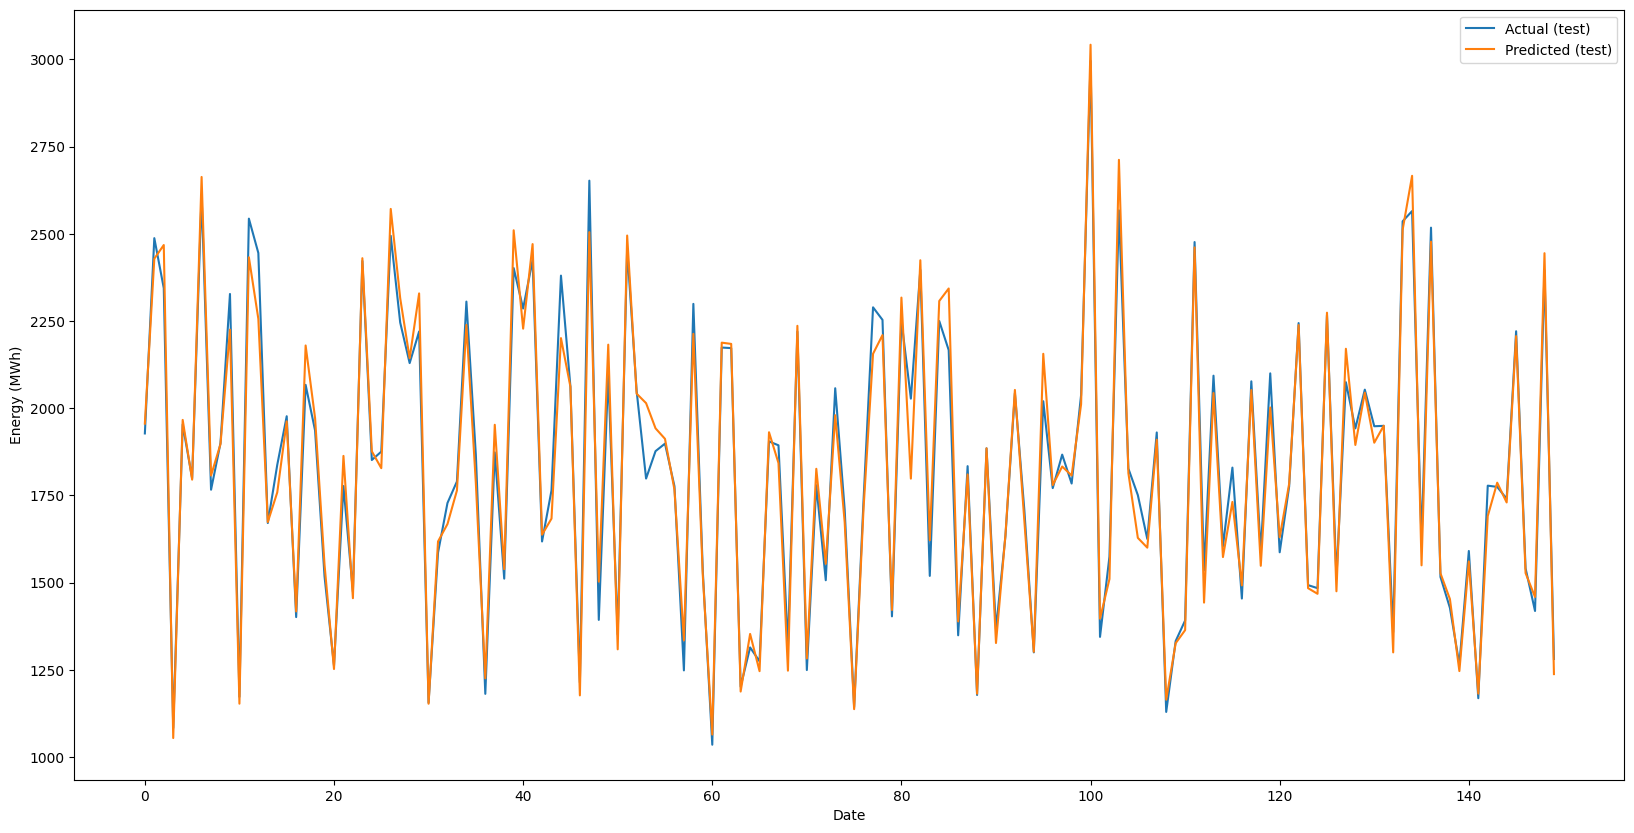

In [31]:
fig = plt.figure(figsize=(20, 10))
# Tahminleri ve gerçek değerleri görselleştir
plt.plot(predict.index[:150], y_test[:150], label='Actual (test)')
plt.plot(predict.index[:150], y_pred[:150], label='Predicted (test)')

plt.xlabel('Date')
plt.ylabel('Energy (MWh)')
plt.legend()
plt.show()

# Final Model

In [33]:
lgbm2 = LGBMRegressor( max_depth= 5 , learning_rate=0.1,  n_estimators=500  )

lgbm2.fit(X, y)

LGBMRegressor(max_depth=5, n_estimators=500)

In [18]:
'''
LGBMRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000)
'''

'\nLGBMRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000)\n'

In [34]:
y_pred_final = lgbm2.predict(predict)
y_pred_final[:10]

array([2213.70491977, 2065.20097874, 1933.67998851, 1882.5679651 ,
       1837.59992842, 1821.58157305, 1803.0901779 , 1935.89858157,
       2319.19049517, 2579.26072442])

In [45]:
future_data= pd.read_csv('sample_submission.csv')
future_data["Dağıtılan Enerji (MWh)"]=y_pred_final
submit_data = future_data.copy()

In [55]:
future_data = future_data.set_index('Tarih', drop=True)
future_data.index = future_data.index.astype('datetime64')
future_data

KeyError: "None of ['Tarih'] are in the columns"

In [58]:
future_data

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2213.704920
2022-08-01 01:00:00,2065.200979
2022-08-01 02:00:00,1933.679989
2022-08-01 03:00:00,1882.567965
2022-08-01 04:00:00,1837.599928
...,...
2022-08-31 19:00:00,2496.342373
2022-08-31 20:00:00,2473.142578
2022-08-31 21:00:00,2406.243637


In [37]:
from eval_metrics import preds_plot

In [41]:
data = pd.read_csv('train.csv' , parse_dates=['Tarih'] , index_col='Tarih')

In [42]:
target_data = data[data.index.month == 8]

In [54]:
target_data

,Dağıtılan Enerji (MWh)
Tarih,
2018-08-01 00:00:00,2106.796778
2018-08-01 01:00:00,1936.871633
2018-08-01 02:00:00,1808.523094
2018-08-01 03:00:00,1725.237068
2018-08-01 04:00:00,1680.685169
...,...
2021-08-31 19:00:00,2538.809761
2021-08-31 20:00:00,2572.939106
2021-08-31 21:00:00,2484.682803


In [52]:
data

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701
...,...
2022-07-31 19:00:00,2492.489498
2022-07-31 20:00:00,2479.958245
2022-07-31 21:00:00,2485.016884


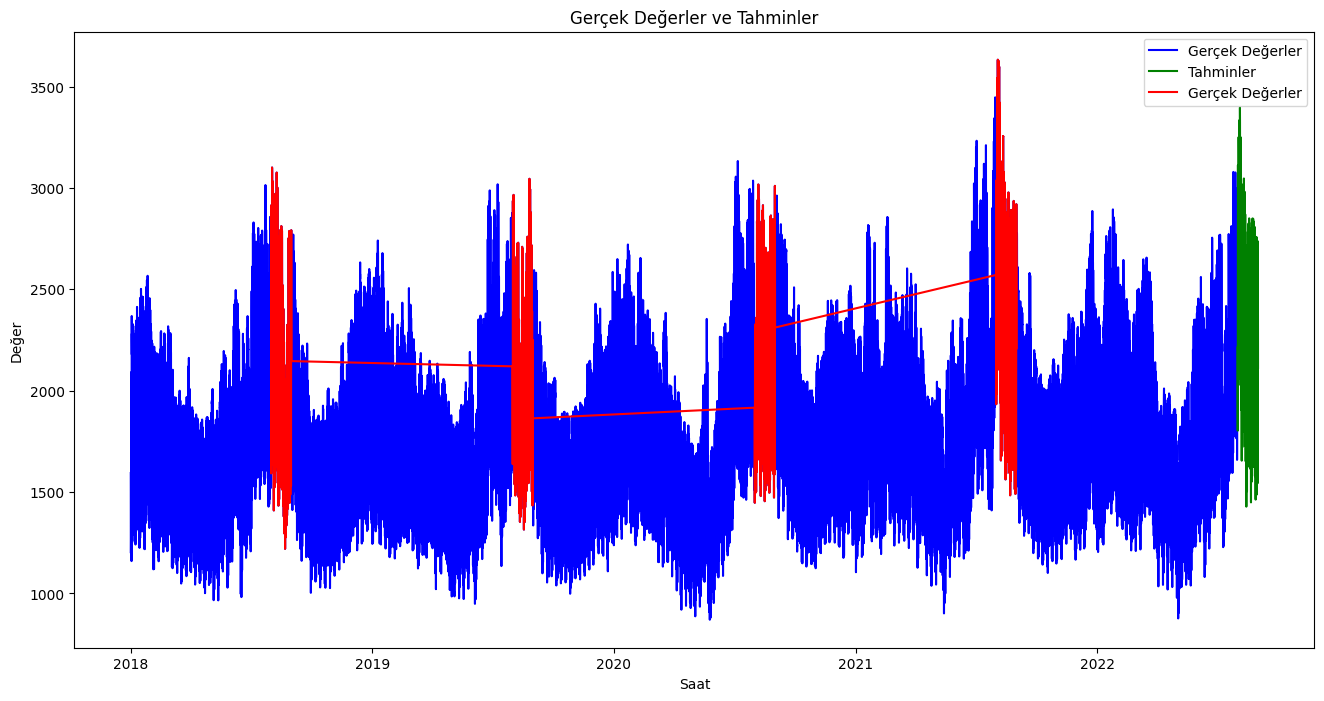

In [61]:
plt.figure(figsize= ( 16 , 8))

preds_plot(data , future_data , target_data)

In [65]:
submit_data['Tarih'] = submit_data['Tarih'].astype('datetime64')
submit_data

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,2213.704920
1,2022-08-01 01:00:00,2065.200979
2,2022-08-01 02:00:00,1933.679989
3,2022-08-01 03:00:00,1882.567965
4,2022-08-01 04:00:00,1837.599928
...,...,...
739,2022-08-31 19:00:00,2496.342373
740,2022-08-31 20:00:00,2473.142578
741,2022-08-31 21:00:00,2406.243637
742,2022-08-31 22:00:00,2231.785410


In [66]:
submit_data.to_csv("LGBM-500-maxd5-lr01.csv",index=None)

In [ ]:
# Done.